In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%capture
import sys
sys.path.append('../')

# Import everything from the data_utils library
from data_utils import *

# Load the talk data
talk_data = get_only_talks(load_data())

In [3]:
# Import libraries and setup matplotlib defaults
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np
pl.style.use('bmh')
prop_cycle = pl.cycler(color=['#377eb8','#e41a1c','#4daf4a','#984ea3',
                              '#ff7f00','#ffff33','#a65628','#f781bf','#999999'])
pl.rcParams.update({
    'axes.prop_cycle': prop_cycle,
    'lines.linewidth': 2,
    'font.size': 20,
    'figure.figsize': [12, 8],
    'figure.subplot.left': 0.125,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.15})

# Referencing the president of the church
It has been observed from time by listeners to general conference that sometimes the speakers seem to speak of or quote the current president of the church more than they do Jesus. The data suggest that while this has happened in individual talks from time to time, in general it is not true. However, it is still an interesting question: how frequently do speakers at general conference talk about the president of the church?

To test this question, I have taken the texts of all conference talks in the available data set and counted how many times in each talk the speaker has mentioned the current president of the church. This could be in the context of quoting them, or of merely talking about them. I checked for use of both the full name, or the use of their last name with the title "President".

## Trends over time
The first plot below shows the annual average rate (over both general conference in a given year) of speakers referencing the current president of the church, during the period 1942-2021, which spans the presidencies of Heber J. Grant through Russell M. Nelson. The background has been shaded to illustrate where each president's term began and ended.

There are a few things to note. First, it is common for speakers to mention the president of the church in his first general conference, and this is apparent in the plot. Second, it appears that talking about the current president of the church was somewhat less common prior to David O. McKay, but that it stayed relatively consistent for nearly 7 decades from the 1950s through the 2010s, averaging between 0.4 and 0.7 mentions per 1000 words. (For reference, the average talk length is between 1000 and 2000 words during this period). Third, something changed in 2018 when Russell Nelson became president of the church. After mentions of him quickly spiked to an all-time high, they have remained at a level above 1 mention per 1000 words in the 4 years since then, which is nearly double the historical average.

In [4]:
apostle_data = load_apostle_data()
cur_apostles = apostle_data[apostle_data['dod'].isna()]['name'].values
president_list = apostle_data[~apostle_data['sdate_p'].isna()]['name']

pres_df = talk_data[['date', 'year', 'decade', 'author', 'president',
                     'word_count', 'rank', 'author_gender']].copy()
for pr in president_list.values:
    idx = talk_data['president']==pr
    lastname = pr.split(' ')[-1]
    if pr=='Joseph Smith':
        altstr = 'Prophet Joseph(?! Smith)'
    elif lastname=='Smith': # "President Smith" is ambiguous
        altstr = 'President Smith'
    else:
        altstr = 'President ' + lastname
    pres_df[pr] = talk_data['body'].str.count(pr) + \
                  talk_data['body'].str.count(altstr)
    pres_df.loc[idx, 'current'] = talk_data.loc[idx, 'body'].str.count(pr) + \
                                  talk_data.loc[idx, 'body'].str.count(altstr)

yearly_totals = pres_df.groupby('year').sum()[['word_count', 'current']]
yearly_usage_rate = yearly_totals['current']/yearly_totals['word_count']*1e3

In [5]:
# only use data since 1995, when GBH became president
pres_recent = pres_df[pres_df['date']>='1995-01-01'].copy()

# keep all current apostles, but group all other men and women speakers into 2 categories
pres_recent['name'] = pres_recent['author'].str.split(' ').str[-1]
pres_recent.loc[pres_recent['author_gender']=='F', 'name'] = 'other (women)'
pres_recent.loc[(pres_recent['author_gender']=='M') &
                (~pres_recent['author'].isin(cur_apostles)), 'name'] = 'other (men)'

# calculate totals
pres_data_totals =  pres_recent.groupby(['name', 'president']) \
    .sum()[['current', 'word_count']].reset_index()

# pivot to making the 3 presidents of interest the columns
pres_data_totals['ratio'] = pres_data_totals['current']/pres_data_totals['word_count']
results = pres_data_totals.set_index('name').pivot(columns='president', values='ratio')*1e3

# compute the averages and add a separate row
total = pres_recent.groupby('president')[['current', 'word_count']].sum()
avg_ratio = total['current']/total['word_count']*1e3
results.loc['average'] = avg_ratio

# order the columns and shorten their names
final = results[['Gordon B. Hinckley', 'Thomas S. Monson', 'Russell M. Nelson']]
final.columns = ['Hinckley', 'Monson', 'Nelson']

# order the rows by getting a seniority list of apostles, and adding the other rows at the end
order = apostle_data[apostle_data['dod'].isna()].sort_values('sdate')['name'] \
    .str.split(' ').str[-1].reset_index(drop=True).reset_index().set_index('name')
for new_str in 'other (men)', 'other (women)', 'average':
    order.loc[new_str, 'index'] = len(order)

final_ordered = final.join(order).sort_values('index').drop(columns='index')

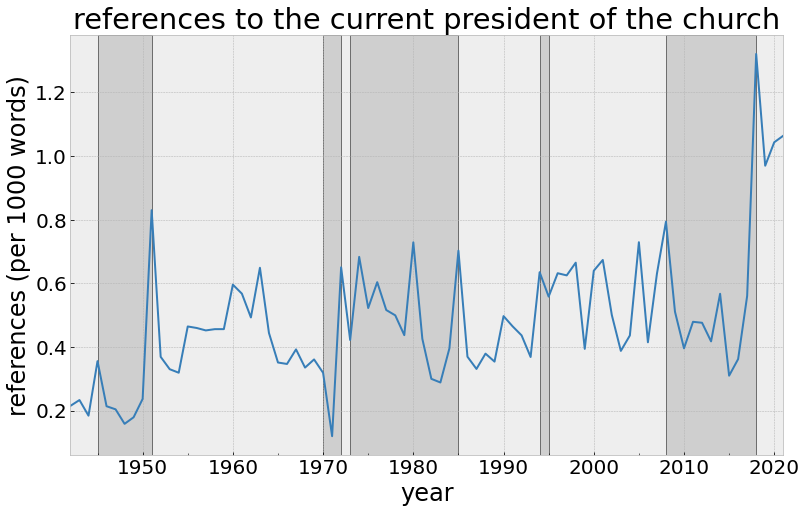

In [6]:
from plot_utils import *

yearly_usage_rate.plot(
    title='references to the current president of the church',
    ylabel='references (per 1000 words)')
add_president_terms()

## Who is talking most about the president of the church?
After observing the sudden jump in mentioning the president of the church that occurred in 2018, a follow-up question might be: who is doing this the most? To asses this, I looked at all talks by all of the current apostles given during the past 3 presidents of the church. That era begins in 1995 when Gordon B. Hinckley became president. I computed the frequency with which each of the apostles mentioned Hinckley, Monson, and Nelson during their respective presidencies. I also included the all other male speakers, all other female speakers, and the averages over all general conference speakers during those eras.

Breaking it out this way reveals a significant divergence in who is talking about or quoting the president of the church. There are 4 outliers who do so with much greater frequency than all the rest: Cook, Rasband, Stevenson, and Andersen. Andersen exceeds all the rest by a significant margin and has done so since the Hinckley era when he was a Seventy.

## Who changed most under Nelson?
Given the significant increase in mentions of the church president under Nelson, it's interesting to ask whether certain apostles changed their patterns significantly. Many of them recorded an increase, but the most significant increases are perhaps David Bednar, who went from barely ever mentioning President Monson, to mentioning President Nelson at a rate above the global average, and D. Todd Christofferson, who recorded a similar increase, but at a slightly lower level. Gerritt Gong is a bit of an outlier due to never having mentioned a president of the church previous to Nelson, but he became an apostle under Nelson, and gave only 2 general conference talks previous to that.

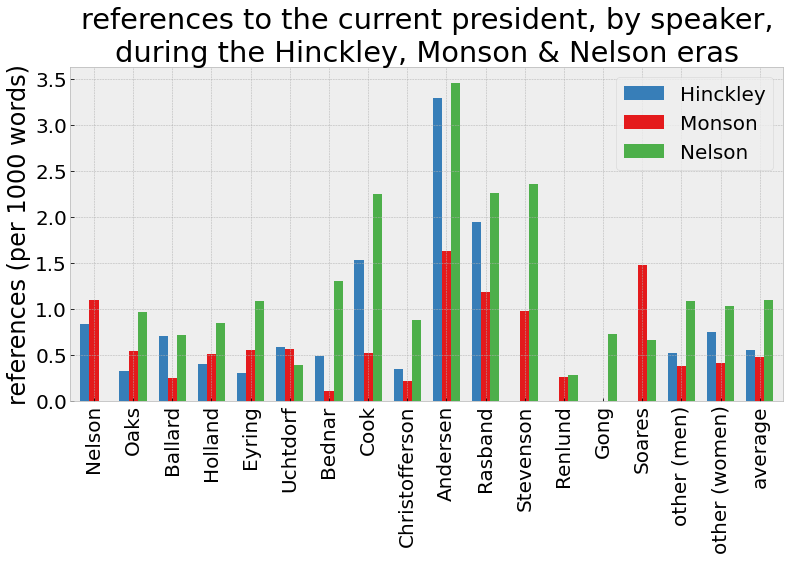

In [7]:
ax = final_ordered.plot.bar(
    width=0.7,
    xlabel='',
    ylabel='references (per 1000 words)',
    title='references to the current president, by speaker,\n'+
    'during the Hinckley, Monson & Nelson eras')
pl.subplots_adjust(bottom=0.3)

## What about past presidents of the church before they were president?
Because of the striking change that occurred under Nelson, it is interesting to consider what presidents of the church did when they were not president. The plot below shows how frequently each president of the church going back to David O. McKay mentioned his predecessors before he became president of the church. It may be indicative of future patterns to observe speaking patterns of potential future presidents of the church. For that reason, I have added current heir apparent Dallin H. Oaks, as well as Jeffrey R. Holland. Holland is not the most senior after Oaks, but based on relative ages, seniority, and actuarial tables, he is the most likely president of the church after a future Oaks presidency.

In [8]:
# Add the heir apparent (and his possible heir apparent) to the list
pl_extended = president_list.append(
    pd.Series(["Dallin H. Oaks", "Jeffrey R. Holland"], index=[100, 101]))
pres_pres_refs = pres_df[pres_df['author'].isin(pl_extended)].copy()

# calculate totals
pres_pres_totals =  pres_pres_refs.groupby(['author', 'president']) \
    .sum()[['current', 'word_count']].reset_index()

# pivot to making the 3 presidents of interest the columns
pres_pres_totals['ratio'] = pres_pres_totals['current']/pres_pres_totals['word_count']
pp_results = pres_pres_totals.set_index('author').pivot(columns='president', values='ratio')*1e3

pp_results_ordered = pp_results.loc[pl_extended[8:], pl_extended[6:-2]]
pp_results_ordered.index = pp_results_ordered.index.str.split(' ').str[-1]
pp_results_ordered.columns = pp_results_ordered.columns.str.split(' ').str[-1]
pp_results_ordered.index.name = 'speaker'

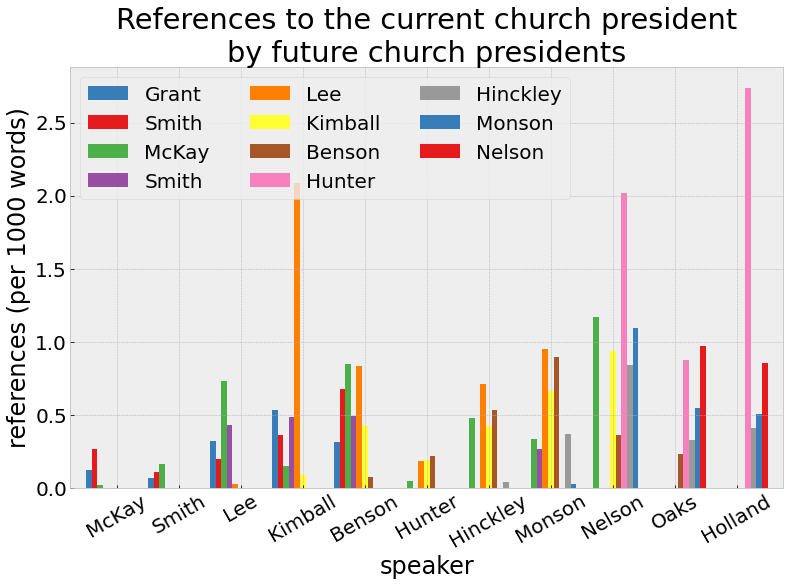

In [9]:
ax = pp_results_ordered.plot.bar(
    width=1, rot=30,
    title='References to the current church president\nby future church presidents',
    ylabel='references (per 1000 words)')
_ = pl.legend(ncol=3)

The magnitude of the bars in the plot above is slightly distorted by the presence of two presidents of the church who served for less than a year: Harold B. Lee and Howard W. Hunter. To make patterns easier to observe, those two have been removed in the plot below.

From this chart we can observe some interesting connections. Ezra Taft Benson seems to have had a particular affinity for David O. McKay when he was president, and Thomas S. Monson for Ezra Taft Benson. It's hard to know whether these represent something significant or not.

It is also particularly notable that President Nelson made a habit of talking about the president of the church significantly more than any of his predecessors. This may be an indicator of what is going on in the current era: he believes it is important to show deference to the president of the church, and expects it from his colleagues now that he's in charge. And, his colleagues are obliging, as is apparent from the fact that both Oaks and Holland have stepped up their talk about the president of the church.

It may be surprising to some to see that Nelson spoke about David O. McKay when he was president of the church, since he was not a general authority before being called an apostle in 1984. In fact, a young Russell Nelson, then a stake president, gave a talk in the priesthood session of general conference in 1969.

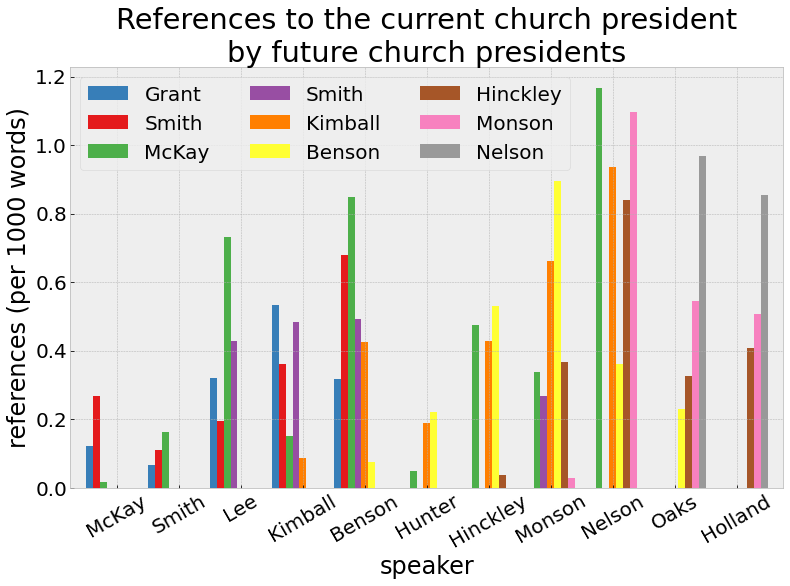

In [10]:
ax = pp_results_ordered.drop(columns=['Lee', 'Hunter']).plot.bar(
    width=1, rot=30,
    title='References to the current church president\nby future church presidents',
    ylabel='references (per 1000 words)')
_ = pl.legend(ncol=3)

## Conclusion
So, what happened in 2018? It's clear from the data that during the presidency of Russell M. Nelson there has been a noticeable increase in the rate of general conference speakers mentioning or quoting the president of the church compared to all previous presidencies. There has always been some variation among the apostles in their tendency to do this, but the increase has been observed in nearly all speakers. There could be a variety of possible explanations for this, including how they feel personally about President Nelson and his leadership, or interpersonal dynamics among the apostles. We can observe from past patterns before Nelson became president of the church that he has always spoken of the president of the church with greater frequency than his predecessors, which suggests that he may personally believe this to be important. It also appears that Nelson's most likely successors didn't previously talk about the president of the church with the same frequency, suggesting things could well revert to previous patterns during future presidencies.

In [11]:
# Setup show/hide source code box
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="show/hide source code"></form>''')